In [3]:
import argparse
import yaml
from tqdm import tqdm
import sys
import copy
from functools import partial
import os



import pickle

import jax
import jaxopt 
from jax.flatten_util import ravel_pytree


jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, build_cdf_mstar
from rikabplotlib.plot_utils import newplot

from utils.fit_utils import randomize_params, freeze_lower_orders, create_mask

# time
from time import time

from helpers.data import get_pdf_toy_JAX, read_in_data_JAX

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Initialization and Setup

In [4]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 1
n = 7
dist = "exponential"  # "thrust" or "exponential"

# number of higher orders
m0 = 1
n0 = 0 # Default is 0

append = ""
tag = f"gaussian_{dist}_stat_m0{m0}{append}"



title_dict = {"thrust": "ALEPH Thrust, 91.2 GeV",
              "exponential": "Exponential [Toy]", 
              "rayleigh" : "Rayleigh [Toy]"}

data_label_dict = {"thrust": "ALEPH Data",
              "exponential": "Pseudodata", 
              "rayleigh" : "Pseudodata"}

x_label_dict = {"thrust": r"Thrust $\tau = 1-T$",
              "exponential": r"$x$", 
              "rayleigh" : r"$x$"}


mult_factor = 2 if dist == "thrust" else 1

T_MAX = 10
gaussian_prior_param = 1.0 # std of g/m!n!
alpha_init = 0.118


zero_error_scale = 1   # Fraction of minimum error to set error on 0, default is 1
lr = 0.0100
weight_decay = 0.00001
epochs = 50000
batch_size = 320*1
seed = 42
freeze_previous_order = False   # NEW
bogo_init = True
random_batch = False

ignore_left = False # Ignore the leftmost point 
x_mask = [0.05, 0.45]

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)



beta_limits = [0, 1e6]
alpha_limits = [0.1, 0.14]






### Aesthetic Setup


In [5]:
order_colors = {1 : "blue", 2 : "purple", 3 : "red"}

# Colors
colors = ["red", "violet", "blue"][::-1]
darkcolors = ["darkred", "darkviolet", "darkblue"][::-1]
order_strings = {1 : r"$\mathcal{O}(\alpha_s^{1})$", 2 : r"$\mathcal{O}(\alpha_s^{2})$", 3 : r"$\mathcal{O}(\alpha_s^{3})$"}


### Parameter Initialization from Fixed Order Calc

In [ ]:
# Init from previous file:

def initialize_params(name_, order):

    # Initialize params
    params_ = {
        "g_star" : -np.zeros((order+2 - mstar, n+1+n0)),
        "g_coeffs" : -np.zeros((order+2 - mstar, n+1+n0)),
        "thetas" : np.zeros((order+2 - mstar,)) ,
        "thetas_coeffs" : np.zeros((order+2 - mstar,)) ,
        "temps" : 1 * np.ones((order+2 - mstar,)),
        "temps_coeffs" : 1 * np.ones((order+2 - mstar,)),
        "temps_positive" : 0.1 * np.ones((order+2 - mstar,)),
    }

    try:
        with open(f"output_fits/{name_}_params.pkl", "rb") as f:
            init_params = copy.deepcopy(pickle.load(f))

        g_coeffs_init = init_params["g_coeffs"]
        g_star_init = init_params["g_star"]
        thetas_init = init_params["thetas"]
        thetas_coeffs_init = init_params["thetas_coeffs"]
        temps_init = init_params["temps"]
        temps_coeffs_init = init_params["temps_coeffs"]
        temps_pos_init = init_params["temps_positive"]


        init_m, init_n = g_coeffs_init.shape

        params_["g_coeffs"][:init_m, :init_n] = copy.deepcopy(g_coeffs_init)
        params_["g_star"][:init_m, :init_n] = copy.deepcopy(g_star_init)
        params_["thetas"][:init_m] = copy.deepcopy(thetas_init)
        params_["thetas_coeffs"][:init_m] = copy.deepcopy(thetas_coeffs_init)
        params_["temps"][:init_m] = copy.deepcopy(temps_init) 
        params_["temps_coeffs"][:init_m] = copy.deepcopy(temps_coeffs_init)
        params_["temps_positive"][:init_m] = copy.deepcopy(temps_pos_init)

        
        

        for k in params_.keys():
            params_[k] = jnp.array(params_[k])

        
        params_["g_coeffs"] = params_["g_coeffs"].at[params_["g_coeffs"].shape[0]-mstar:,:].set(0)  # Current order doesn't count
        params_["thetas_coeffs"] = params_["thetas_coeffs"].at[params_["thetas_coeffs"].shape[0]-mstar:,].set(-1)  # Current order doesn't count
        params_["temps_coeffs"] = params_["temps_coeffs"].at[params_["temps_coeffs"].shape[0]-mstar:,].set(1e-1)  # Current order doesn't count


        return copy.deepcopy(params_)
    
    except:
        print(f"No file" + f"output_fits/{name_}_params.pkl")
        


params1 = initialize_params(f"{dist}_m1_n{n}", 1 + m0 -1)
params2 = initialize_params(f"{dist}_m2_n{n}", 2 + m0 -1)
params3 = initialize_params(f"{dist}_m3_n{n}", 3 + m0 -1)




factorials = np.ones_like(params3["g_star"])
for mi in range(params3["g_star"].shape[0]):
    for ni in range(params3["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)



params_array = [params1, params2, params3]

def np_to_jax(p):

    for k in p.keys():
        p[k] = jnp.array(p[k])

    return p

params1 = np_to_jax(params1)
params2 = np_to_jax(params2)
params3 = np_to_jax(params3)



# if init_from:
#     params = init_params(init_from)

# # Save the original params for the purpose of freezing
# original_params = params.copy()

# Compilation

In [7]:

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))
cdf_vmap = jax.vmap(build_cdf_mstar(mstar), in_axes=(0,None,None,None,None,None,None,None,None))

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
cdf_vmap2 = jax.vmap(cdf_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))


# Helper functions

ns = jnp.arange(0, n+1+n0)
t_reg = 1.0 #/ jnp.mean(0.5)
twopi = 1 #s2 * jnp.pi
t_pows = jnp.power(t_reg, ns)


@partial(jax.jit, static_argnames=())
def Q_ANSATZ(ts, alpha, params):



    orders = jnp.arange(params["g_star"].shape[0]) + mstar  # physical power index per row
    tscale = t_pows[None, :]                                 # (1, n+1)
    ascale = ((alpha / twopi ) ** orders)[:, None]                      # (m_rows, 1)

    g_star = params["g_star"].at[-m0:].set(params["g_star"][-m0:] / ascale[-m0:] * tscale)
    g_coeffs = params["g_coeffs"].at[-m0-mstar:-mstar].set(params["g_coeffs"][-m0-mstar:-mstar] / ascale[-m0-mstar:-mstar] * tscale)

     # Positive temps
    temps = params["temps"].at[-m0:].set( jax.nn.softplus( params["temps"][-m0:]))
    temps_coeffs = params["temps_coeffs"].at[-m0-mstar:-mstar].set( jax.nn.softplus(params["temps_coeffs"][-m0-mstar:-mstar]))
    temps_pos = params["temps_positive"].at[-m0:].set(jax.nn.softplus( params["temps_positive"][-m0:]))
    temps_coeffs = temps_coeffs.at[-mstar:].set(1e-1)

    g_coeffs = g_coeffs.at[g_coeffs.shape[0]-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = params["thetas_coeffs"].at[g_coeffs.shape[0]-mstar:,].set(-1)  # Current order doesn't count
    temps_coeffs = temps_coeffs.at[g_coeffs.shape[0]-mstar:,].set(1e-1)  # Current order doesn't count



    return q_vmap(ts, alpha, g_star, g_coeffs,
                  params["thetas"], thetas_coeffs,
                 temps, temps_coeffs, temps_pos)


@partial(jax.jit, static_argnames=())
def CDF_ANSATZ(ts, alpha, params):



    orders = jnp.arange(params["g_star"].shape[0]) + mstar  # physical power index per row
    tscale = t_pows[None, :]                                 # (1, n+1)
    ascale = ((alpha / twopi ) ** orders)[:, None]                      # (m_rows, 1)

    g_star = params["g_star"].at[-m0:].set(params["g_star"][-m0:] / ascale[-m0:] * tscale)
    g_coeffs = params["g_coeffs"].at[-m0-mstar:-mstar].set(params["g_coeffs"][-m0-mstar:-mstar] / ascale[-m0-mstar:-mstar] * tscale)

     # Positive temps
    temps = params["temps"].at[-m0:].set( jax.nn.softplus( params["temps"][-m0:]))
    temps_coeffs = params["temps_coeffs"].at[-m0-mstar:-mstar].set( jax.nn.softplus(params["temps_coeffs"][-m0-mstar:-mstar]))
    temps_pos = params["temps_positive"].at[-m0:].set(jax.nn.softplus( params["temps_positive"][-m0:]))
    temps_coeffs = temps_coeffs.at[-mstar:].set(1e-1)

    g_coeffs = g_coeffs.at[g_coeffs.shape[0]-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = params["thetas_coeffs"].at[g_coeffs.shape[0]-mstar:,].set(-1)  # Current order doesn't count
    temps_coeffs = temps_coeffs.at[g_coeffs.shape[0]-mstar:,].set(1e-1)  # Current order doesn't count



    return cdf_vmap(ts, alpha, g_star, g_coeffs,
                  params["thetas"], thetas_coeffs,
                 temps, temps_coeffs, temps_pos)

# Data Setup

Opal Data from https://www.hepdata.net/record/ins440721?version=1&table=Table%203

ALEPH Data from https://www.hepdata.net/record/ins636645?version=1&table=Table%2054

In [8]:

LEP = {
    "THRUST": 1-np.array([
        0.585,0.595,0.605,0.615,0.625,0.635,0.645,0.655,0.665,0.675,
        0.685,0.695,0.705,0.715,0.725,0.735,0.745,0.755,0.765,0.775,
        0.785,0.795,0.805,0.815,0.825,0.835,0.845,0.855,0.865,0.875,
        0.885,0.895,0.905,0.915,0.925,0.935,0.945,0.955,0.965,0.975,
        0.985,0.995
    ]),
    "THRUST_HIGH": 1-np.array([
        0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,
        0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,
        0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,
        0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,
        0.98,0.99
    ]),
    "THRUST_LOW": 1-np.array([
        0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,
        0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,
        0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,
        0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,
        0.99,1.0
    ]),
    "DSIG": np.array([
        0.00115,0.00229,0.0035,0.00839,0.01283,0.02148,0.0433,0.06556,0.10284,0.12575,
        0.16396,0.18416,0.21424,0.24814,0.29427,0.34347,0.36536,0.43088,0.46923,0.54584,
        0.59942,0.66087,0.768,0.857,0.98079,1.1127,1.27035,1.43939,1.63938,1.93459,
        2.23002,2.63072,3.06214,3.70212,4.54709,5.64464,7.27722,9.62952,13.60396,18.56511,
        12.88646,1.31186
    ]),
    "stat_plus": np.array([
        0.00034,0.0005,0.00061,0.00096,0.00116,0.00152,0.00223,0.00267,0.00334,0.00366,
        0.00418,0.00449,0.00466,0.00511,0.00567,0.00609,0.00614,0.00691,0.00709,0.0079,
        0.00814,0.00856,0.00928,0.00974,0.0106,0.01125,0.01209,0.01339,0.01372,0.01504,
        0.01641,0.01811,0.01892,0.02073,0.02343,0.02568,0.02929,0.03385,0.04085,0.04923,
        0.03872,0.00986
    ]),
    "stat_minus": np.array([
        -0.00034,-0.0005,-0.00061,-0.00096,-0.00116,-0.00152,-0.00223,-0.00267,-0.00334,-0.00366,
        -0.00418,-0.00449,-0.00466,-0.00511,-0.00567,-0.00609,-0.00614,-0.00691,-0.00709,-0.0079,
        -0.00814,-0.00856,-0.00928,-0.00974,-0.0106,-0.01125,-0.01209,-0.01339,-0.01372,-0.01504,
        -0.01641,-0.01811,-0.01892,-0.02073,-0.02343,-0.02568,-0.02929,-0.03385,-0.04085,-0.04923,
        -0.03872,-0.00986
    ]),
    "sys1_plus": np.array([
        0.00052,0.00093,0.00087,0.00077,0.00082,0.00095,0.00496,0.00273,0.00353,0.00297,
        0.00474,0.00871,0.00455,0.01328,0.00573,0.00801,0.00707,0.00868,0.01309,0.00687,
        0.00809,0.02434,0.0152,0.01211,0.01281,0.00939,0.00874,0.00965,0.02383,0.02559,
        0.0291,0.01555,0.03499,0.0235,0.03555,0.03708,0.0454,0.07026,0.07561,0.08476,
        0.22928,0.19542
    ]),
    "sys1_minus": np.array([
        -0.00052,-0.00093,-0.00087,-0.00077,-0.00082,-0.00095,-0.00496,-0.00273,-0.00353,-0.00297,
        -0.00474,-0.00871,-0.00455,-0.01328,-0.00573,-0.00801,-0.00707,-0.00868,-0.01309,-0.00687,
        -0.00809,-0.02434,-0.0152,-0.01211,-0.01281,-0.00939,-0.00874,-0.00965,-0.02383,-0.02559,
        -0.0291,-0.01555,-0.03499,-0.0235,-0.03555,-0.03708,-0.0454,-0.07026,-0.07561,-0.08476,
        -0.22928,-0.19542
    ]),
    "sys2_plus": np.array([
        0.00033,0.00065,0.001,0.0017,0.0026,0.00436,0.00307,0.00464,0.00728,0.00984,
        0.01283,0.01441,0.01503,0.01741,0.02065,0.01874,0.01993,0.0235,0.01728,0.0201,
        0.02208,0.02607,0.0303,0.03381,0.04685,0.05316,0.06069,0.052,0.05922,0.06989,
        0.06846,0.08076,0.09401,0.07685,0.09439,0.11718,0.11117,0.1471,0.20781,0.68299,
        0.47408,0.04826
    ]),
    "sys2_minus": np.array([
        -0.00033,-0.00065,-0.001,-0.0017,-0.0026,-0.00436,-0.00307,-0.00464,-0.00728,-0.00984,
        -0.01283,-0.01441,-0.01503,-0.01741,-0.02065,-0.01874,-0.01993,-0.0235,-0.01728,-0.0201,
        -0.02208,-0.02607,-0.0303,-0.03381,-0.04685,-0.05316,-0.06069,-0.052,-0.05922,-0.06989,
        -0.06846,-0.08076,-0.09401,-0.07685,-0.09439,-0.11718,-0.11117,-0.1471,-0.20781,-0.68299,
        -0.47408,-0.04826
    ]),
}


OPAL = {
    "THRUST": 1-np.array([0.74,0.815,0.865,0.895,0.92,0.94,0.955,0.965,0.975,0.985,0.995]),
    "THRUST_HIGH": 1-np.array([0.7,0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99]),
    "THRUST_LOW": 1-np.array([0.78,0.85,0.88,0.91,0.93,0.95,0.96,0.97,0.98,0.99,1.0]),
    "DSIG": np.array([0.14,0.93,1.02,3.1,3.56,3.92,6.5,10.1,18.1,22.1,8.6]),
    "stat_plus": np.array([0.12,0.24,0.39,0.64,0.82,0.84,1.5,1.9,2.5,2.9,1.7]),
    "stat_minus": np.array([-0.12,-0.24,-0.39,-0.64,-0.82,-0.84,-1.5,-1.9,-2.5,-2.9,-1.7]),
    "sys_plus": np.array([0.47,0.47,0.61,0.59,0.81,1.29,1.4,1.6,2.6,2.6,2.6]),
    "sys_minus": np.array([-0.47,-0.47,-0.61,-0.59,-0.81,-1.29,-1.4,-1.6,-2.6,-2.6,-2.6]),
}



LEP_C = {
    "C_PARAMETER": np.array([
        0.01,0.03,0.05,0.07,0.09,0.11,0.13,0.15000000000000002,0.16999999999999998,0.19,
        0.21000000000000002,0.22999999999999998,0.25,0.27,0.29000000000000004,0.31,0.33,0.35,
        0.37,0.39,0.41000000000000003,0.43,0.45,0.47,0.49,0.51,0.53,0.55,0.5700000000000001,
        0.59,0.61,0.63,0.65,0.67,0.69,0.71,0.73,0.75,0.77,0.79,0.81,0.83,0.85,0.87,0.89,
        0.91,0.9299999999999999,0.95,0.97,0.99
    ]),
    "C_PARAMETER_LOW": np.array([
        0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,
        0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,
        0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,
        0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,
        0.88,0.9,0.92,0.94,0.96,0.98
    ]),
    "C_PARAMETER_HIGH": np.array([
        0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,
        0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,
        0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,
        0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,
        0.9,0.92,0.94,0.96,0.98,1.0
    ]),
    # (1/SIG) * d(SIG)/dC
    "DSIG": np.array([
        0.06711,0.17252,0.99038,2.63786,4.05142,4.37476,3.97532,3.42243,2.92973,2.54854,
        2.25012,1.97701,1.80134,1.60594,1.45321,1.29952,1.18603,1.08169,1.01995,0.92768,
        0.86267,0.79512,0.75074,0.69408,0.62931,0.60227,0.5587,0.53272,0.50388,0.45918,
        0.42642,0.40984,0.37779,0.35563,0.34,0.32205,0.30286,0.28838,0.27147,0.22742,
        0.17542,0.11919,0.08324,0.05707,0.03548,0.02111,0.01266,0.00892,0.00292,0.00091
    ]),
    "stat_plus": np.array([
        0.00206,0.00263,0.00696,0.01272,0.01632,0.0169,0.01579,0.01428,0.01312,0.01221,
        0.01154,0.0108,0.01055,0.00982,0.0093,0.00868,0.00832,0.00791,0.00784,0.00744,
        0.00711,0.00706,0.00729,0.00639,0.00597,0.00588,0.0057,0.0058,0.00539,0.00505,
        0.00483,0.00477,0.00455,0.00444,0.00434,0.00414,0.00404,0.00393,0.00378,0.00347,
        0.00305,0.00244,0.00204,0.00168,0.00131,0.00105,0.00078,0.00073,0.00039,0.00026
    ]),
    "stat_minus": np.array([
        -0.00206,-0.00263,-0.00696,-0.01272,-0.01632,-0.0169,-0.01579,-0.01428,-0.01312,-0.01221,
        -0.01154,-0.0108,-0.01055,-0.00982,-0.0093,-0.00868,-0.00832,-0.00791,-0.00784,-0.00744,
        -0.00711,-0.00706,-0.00729,-0.00639,-0.00597,-0.00588,-0.0057,-0.0058,-0.00539,-0.00505,
        -0.00483,-0.00477,-0.00455,-0.00444,-0.00434,-0.00414,-0.00404,-0.00393,-0.00378,-0.00347,
        -0.00305,-0.00244,-0.00204,-0.00168,-0.00131,-0.00105,-0.00078,-0.00073,-0.00039,-0.00026
    ]),
    "sys1_plus": np.array([
        0.06509,0.01442,0.02565,0.05487,0.04694,0.02342,0.02199,0.02026,0.02512,0.01471,
        0.01269,0.02161,0.01908,0.01097,0.00687,0.01328,0.01153,0.00587,0.00483,0.0082,
        0.00982,0.00405,0.01128,0.00353,0.0118,0.00746,0.01023,0.0099,0.0055,0.01068,
        0.00323,0.00518,0.00289,0.00993,0.00323,0.00484,0.0048,0.00401,0.00518,0.0072,
        0.00384,0.00337,0.00515,0.00315,0.00368,0.0018,0.00131,0.00101,0.00034,0.00024
    ]),
    "sys1_minus": np.array([
        -0.06509,-0.01442,-0.02565,-0.05487,-0.04694,-0.02342,-0.02199,-0.02026,-0.02512,-0.01471,
        -0.01269,-0.02161,-0.01908,-0.01097,-0.00687,-0.01328,-0.01153,-0.00587,-0.00483,-0.0082,
        -0.00982,-0.00405,-0.01128,-0.00353,-0.0118,-0.00746,-0.01023,-0.0099,-0.0055,-0.01068,
        -0.00323,-0.00518,-0.00289,-0.00993,-0.00323,-0.00484,-0.0048,-0.00401,-0.00518,-0.0072,
        -0.00384,-0.00337,-0.00515,-0.00315,-0.00368,-0.0018,-0.00131,-0.00101,-0.00034,-0.00024
    ]),
    "sys2_plus": np.array([
        0.00359,0.00923,0.05299,0.13588,0.2087,0.22536,0.07322,0.06303,0.05396,0.02651,
        0.02341,0.02057,0.01403,0.01251,0.01132,0.03732,0.03407,0.03107,0.03409,0.03101,
        0.02883,0.02006,0.01894,0.01751,0.02304,0.02205,0.02045,0.01804,0.01707,0.01555,
        0.02101,0.02019,0.01861,0.01378,0.01317,0.01248,0.01338,0.01274,0.01199,0.02049,
        0.01581,0.01074,0.0101,0.00693,0.00431,0.00442,0.00265,0.00187,0.00065,0.0002
    ]),
    "sys2_minus": np.array([
        -0.00359,-0.00923,-0.05299,-0.13588,-0.2087,-0.22536,-0.07322,-0.06303,-0.05396,-0.02651,
        -0.02341,-0.02057,-0.01403,-0.01251,-0.01132,-0.03732,-0.03407,-0.03107,-0.03409,-0.03101,
        -0.02883,-0.02006,-0.01894,-0.01751,-0.02304,-0.02205,-0.02045,-0.01804,-0.01707,-0.01555,
        -0.02101,-0.02019,-0.01861,-0.01378,-0.01317,-0.01248,-0.01338,-0.01274,-0.01199,-0.02049,
        -0.01581,-0.01074,-0.0101,-0.00693,-0.00431,-0.00442,-0.00265,-0.00187,-0.00065,-0.0002
    ]),
}


def add_total_error_columns(d,):

    running_err2 = d["stat_plus"]**2
    # for key in d.keys():
    #     if "sys" in key and "plus" in key:
    #         running_err2 += d[key]**2

    d["total_err"] = np.sqrt(running_err2)

    return d

LEP = add_total_error_columns(LEP)
OPAL = add_total_error_columns(OPAL)

LEP_C = add_total_error_columns(LEP_C)

print(LEP["DSIG"])
print(LEP["total_err"])

[1.150000e-03 2.290000e-03 3.500000e-03 8.390000e-03 1.283000e-02
 2.148000e-02 4.330000e-02 6.556000e-02 1.028400e-01 1.257500e-01
 1.639600e-01 1.841600e-01 2.142400e-01 2.481400e-01 2.942700e-01
 3.434700e-01 3.653600e-01 4.308800e-01 4.692300e-01 5.458400e-01
 5.994200e-01 6.608700e-01 7.680000e-01 8.570000e-01 9.807900e-01
 1.112700e+00 1.270350e+00 1.439390e+00 1.639380e+00 1.934590e+00
 2.230020e+00 2.630720e+00 3.062140e+00 3.702120e+00 4.547090e+00
 5.644640e+00 7.277220e+00 9.629520e+00 1.360396e+01 1.856511e+01
 1.288646e+01 1.311860e+00]
[0.00034 0.0005  0.00061 0.00096 0.00116 0.00152 0.00223 0.00267 0.00334
 0.00366 0.00418 0.00449 0.00466 0.00511 0.00567 0.00609 0.00614 0.00691
 0.00709 0.0079  0.00814 0.00856 0.00928 0.00974 0.0106  0.01125 0.01209
 0.01339 0.01372 0.01504 0.01641 0.01811 0.01892 0.02073 0.02343 0.02568
 0.02929 0.03385 0.04085 0.04923 0.03872 0.00986]


-0.8681266553774567


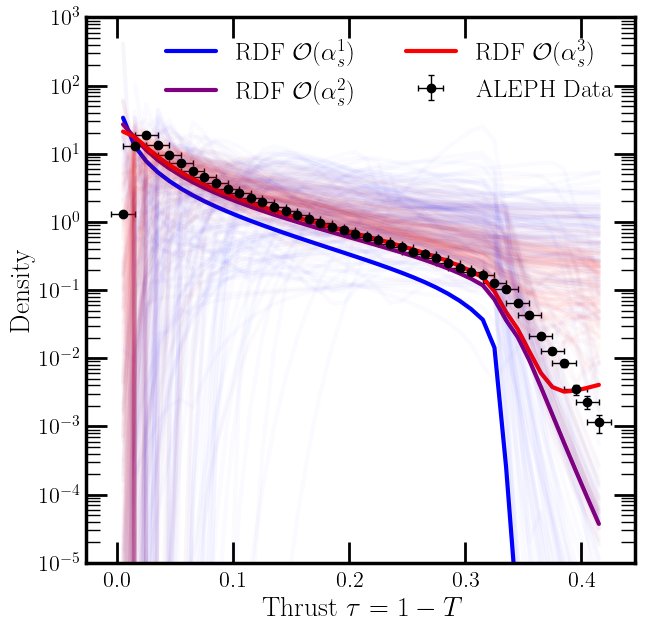

In [9]:
if dist == "thrust":

    xLEP_bin_centers = LEP["THRUST"]
    tLEP_bin_centers = np.log(1/(2 * xLEP_bin_centers))
    
    min_value = np.exp(-T_MAX ) / 2


    xLEP_low = LEP["THRUST_LOW"]
    xLEP_high = LEP["THRUST_HIGH"]

 

    xLEP_low = np.clip(xLEP_low, min_value, None)
    xLEP_high = np.clip(xLEP_high, min_value, None)

    tLEP_low = np.log(1/(2 * xLEP_low))
    tLEP_high = np.log(1/(2 * xLEP_high))


    xlow =  LEP["THRUST_LOW"]
    xhigh = LEP["THRUST_HIGH"]
    xLEP_bin_widths = (xhigh-xlow) 

    yLEPs = LEP["DSIG"]

    yLEP_errs = LEP["total_err"]

    if ignore_left:

        xLEP_mask =  (xLEP_bin_centers < x_mask[0]) + (xLEP_bin_centers > x_mask[1])

        mask_indices_LEP = np.arange(xLEP_mask.shape[0])[xLEP_mask]

        yLEP_errs[mask_indices_LEP] = yLEP_errs[mask_indices_LEP] *  1000

 

    x_bin_centers = np.sort(np.concatenate([ xLEP_bin_centers, ]))
    t_bin_centers =(np.log(1/(2 * x_bin_centers)))
    ys = np.concatenate([yLEPs, ])
    y_errs = np.concatenate([yLEP_errs, ])

elif dist == "c_param":

    xLEP_bin_centers = LEP_C["C_PARAMETER"]
    tLEP_bin_centers = np.log(1/(1 * xLEP_bin_centers))
    
    min_value = np.exp(-T_MAX ) / 1


    xLEP_low = LEP_C["C_PARAMETER_LOW"]
    xLEP_high = LEP_C["C_PARAMETER_HIGH"]

 

    xLEP_low = np.clip(xLEP_low, min_value, None)
    xLEP_high = np.clip(xLEP_high, min_value, None)

    tLEP_low = np.log(1/(1 * xLEP_low))
    tLEP_high = np.log(1/(1 * xLEP_high))


    xlow =  LEP_C["C_PARAMETER_LOW"]
    xhigh = LEP_C["C_PARAMETER_HIGH"]
    xLEP_bin_widths = (xhigh-xlow) 

    yLEPs = LEP_C["DSIG"]

    yLEP_errs = LEP_C["total_err"]

    if ignore_left:

        xLEP_mask =  (xLEP_bin_centers < 2*x_mask[0]) + (xLEP_bin_centers > 2*x_mask[1])
        mask_indices_LEP = np.arange(xLEP_mask.shape[0])[xLEP_mask]
        yLEP_errs[mask_indices_LEP] = yLEP_errs[mask_indices_LEP] *  1000

 

    x_bin_centers = np.sort(np.concatenate([xLEP_bin_centers, ]))
    t_bin_centers =(np.log(1/(1 * x_bin_centers)))
    ys = np.concatenate([yLEPs, ])
    y_errs = np.concatenate([yLEP_errs,])


elif dist == "rayleigh":

    def sample_from_rayleigh(seed, alpha, shape=(1,)):

        alpha_bar = alpha
        u = jax.random.uniform(seed, shape=shape)
        scale = 1.0 / jnp.sqrt(alpha_bar)
        t = scale * jnp.sqrt(-2.0 * jnp.log(u))
        return t

    N_data = 250000
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_rayleigh(seed, 0.118, shape=(N_data,))
    x_data = jnp.exp(-t_data)

    counts, bins = np.histogram(x_data, bins = 40, range = [0, 1], density = True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    yerr = np.sqrt(counts / N_data / (bins[1] - bins[0]))

    xLEP_bin_centers = bin_centers
    tLEP_bin_centers = np.log(1/bin_centers)
    yLEPs = counts
    xLEP_bin_widths =  bins[1:] - bins[:-1]
    yLEP_errs = yerr 

    x_bin_centers = bin_centers
    t_bin_centers = np.log(1/bin_centers)



elif dist == "exponential":

    def sample_from_exponential(seed, beta, shape=(1,)):

        beta_bar = beta
        u = jax.random.exponential(seed, shape=shape)
        scale = 1.0 / beta_bar
        t = scale * u
        return t

    N_data = 250000
    seed = jax.random.PRNGKey(0)
    t_data = sample_from_exponential(seed, 0.118, shape=(N_data,))
    x_data = jnp.exp(-t_data)

    counts, bins = np.histogram(x_data, bins = 40, range = [0, 1], density = True)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    yerr = np.sqrt(counts / N_data / (bins[1] - bins[0]))

    xLEP_bin_centers = bin_centers
    tLEP_bin_centers = np.log(1/bin_centers)
    yLEPs = counts
    xLEP_bin_widths =  bins[1:] - bins[:-1]
    yLEP_errs = yerr 

    x_bin_centers = bin_centers
    t_bin_centers = np.log(1/bin_centers)

# Plot data


fig, ax = newplot("full")
plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "ALEPH Data")



q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, params1) / x_bin_centers #* mult_factor
q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, params2) / x_bin_centers #* mult_factor
q_vals3 = Q_ANSATZ(t_bin_centers, alpha_init, params3) / x_bin_centers #* mult_factor




plt.plot(x_bin_centers, q_vals1, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1)$")
plt.plot(x_bin_centers, q_vals2, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2)$")
plt.plot(x_bin_centers, q_vals3, color = "red", label = r"RDF $\mathcal{O}(\alpha_s^3)$")



for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals1 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params1, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor

    plt.plot(x_bin_centers, q_vals1, color = "blue", alpha = 0.02)


for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals2 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params2, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor
    plt.plot(x_bin_centers, q_vals2, color = "purple", alpha = 0.02)

for i in range(100):
    jax_key, subkey = jax.random.split(jax_key)
    q_vals3 = Q_ANSATZ(t_bin_centers, alpha_init, randomize_params(params3, scale = 1/1, key=subkey, m0 = m0, mstar = mstar)) / x_bin_centers #* mult_factor
    plt.plot(x_bin_centers, q_vals3, color = "red", alpha = 0.02)

# plt.plot(x_bin_centers, q_taylor_vals)

print(np.trapz(Q_ANSATZ(t_bin_centers, alpha_init, params2), t_bin_centers))

plt.ylim(1e-5, 1e3)

plt.legend(ncol = 2)

plt.yscale("log")


plt.xlabel(r"Thrust $\tau = 1-T$")
plt.ylabel(r"Density")

plt.savefig(f"figures/{dist}_data.pdf")




# fig, ax = newplot("full")
# plt.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "ALEPH Data")


# x_edges = jnp.concatenate([jnp.array(xLEP_low[:1]), jnp.array(xLEP_high)])
# x_widths = x_edges[:-1] - x_edges[1:]
# t_edges = jnp.log(1.0 / (mult_factor * x_edges))

# q_vals1 = CDF_ANSATZ(t_edges, alpha_init, params1)  #* mult_factor
# q_vals2 = CDF_ANSATZ(t_edges, alpha_init, params2)  #* mult_factor
# q_vals3 = CDF_ANSATZ(t_edges, alpha_init, params3)  #* mult_factor




# plt.plot(x_bin_centers[::-1], jnp.abs(q_vals1[1:] - q_vals1[:-1]) / x_widths, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1)$")
# plt.plot(x_bin_centers[::-1], jnp.abs(q_vals2[1:] - q_vals2[:-1]) / x_widths, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2)$")
# plt.plot(x_bin_centers[::-1], jnp.abs(q_vals3[1:] - q_vals3[:-1]) / x_widths, color = "red", label = r"RDF $\mathcal{O}(\alpha_s^3)$")

# plt.yscale("log")


(2000,)
(2000,)
{'g_coeffs': Array([[ -0.18114362,  -0.16593951,  -0.126428  ,   0.22419772,
          0.86814114,  -7.99217602,  17.81710128, -12.96526761],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]],      dtype=float64), 'g_star': Array([[ 3.17252845e-01, -1.01050961e+00,  8.77493769e-02,
        -3.35605927e-02,  2.47519743e-02, -3.30073126e-02,
         1.72751043e-02, -1.35949158e-04],
       [-3.94870832e-02, -3.66946918e-02, -6.20711322e-02,
        -9.71018375e-02,  6.36957759e-03,  9.19680866e-01,
         5.44274171e-01, -5.67687652e+00]], dtype=float64), 'temps': Array([0.70104337, 3.71471069], dtype=float64), 'temps_coeffs': Array([1.67199471, 0.1       ], dtype=float64), 'temps_positive': Array([ 8.04497528, -6.03433687], dtype=float64), 'thetas': Array([0.42789569, 0.35274424], dtype=float64), 'thetas_coeffs': Array([-0.48754377, -1.        ], dtype=float64)}
{'g_coeffs': Array([[ -0.180

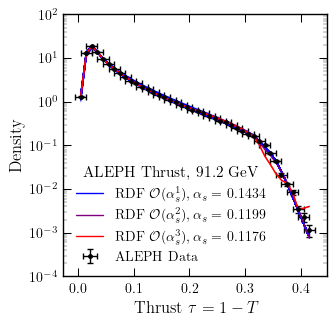

In [ ]:
fig, ax = newplot("column")

ax.errorbar(xLEP_bin_centers, yLEPs, yerr=yLEP_errs, xerr = xLEP_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = data_label_dict[dist])

# # Ratio Plot
# ax[1].errorbar(xLEP_bin_centers, 0 * yLEPs, yerr=1, xerr = xLEP_bin_widths, fmt='o', color='black', lw=1, capsize=2, label = "ALEPH Data")
best_fits = []

for mi in range(1, 4): 

    # try:

    
        with open(f"output_fits/alphas_{mi}_{n}_{tag}.pkl", "rb") as f:
            alphas = np.array(pickle.load(f))

        with open(f"output_fits/ls_{mi}_{n}_{tag}.pkl", "rb") as f:
            ls = np.array(pickle.load(f))

        with open(f"output_fits/params_{mi}_{n}_{tag}.pkl", "rb") as f:
            ps = np.array(pickle.load(f))


        idx = np.argsort(alphas)
        alphas = alphas[idx]
        ls = ls[idx]
        ps = ps[idx]

        # # For repeated alphas, take the minimum loss
        # unique_alphas, unique_indices = np.unique(alphas, return_index=True)
        # min_ls = []
        # min_ps = []
        # for ua in unique_alphas:
        #     mask = alphas == ua
        #     min_ls.append(np.min(ls[mask]))
        #     min_ps.append(ps[np.argmin(ls[mask])])
        # alphas = unique_alphas
        # ls = np.array(min_ls)
        # ps = np.array(min_ps)



        print(ps.shape)
        print(ls.shape)

        print(ps[0])
        print(ps[1])
        print(ps[2])


        ls2 = 2 * ls

        min_ls = np.min(ls2)
        ls2 = ls2 - min_ls
        min_alpha = alphas[np.argmin(ls2)]
        min_params = ps[np.argmin(ls2)]
        best_fits.append(min_alpha)

        alphas_below = alphas[ls2 < 1 + np.min(ls2)]
        low_alpha = alphas_below[0]
        high_alpha = alphas_below[-1]

        params_below = ps[ls2 < 1 + np.min(ls2)]
        ls_below = ls2[ls2 < 1 + np.min(ls2)]

        likelihoods = np.exp(-5 * (ls2 - np.min(ls2)))


        # Best Fit
        q_vals_best = Q_ANSATZ(t_bin_centers, min_alpha, min_params) / x_bin_centers #* mult_factor
        # plt.plot(x_bin_centers, q_vals_best, color = order_colors[mi], alpha = 1)

        for i, a in enumerate(alphas):
            if i % 10 == 0:
                q_vals = Q_ANSATZ(t_bin_centers, a, min_params) / x_bin_centers #* mult_factor
                ax.plot(x_bin_centers, q_vals, color = order_colors[mi], alpha = likelihoods[i])

                # Best Fit
        q_vals_best = Q_ANSATZ(t_bin_centers, min_alpha, min_params) / x_bin_centers #* mult_factor
        plt.plot(x_bin_centers, q_vals_best, color = order_colors[mi], alpha = 1)




plt.ylim(1e-4, 1e2)

ax.set_yscale("log")


plt.yscale("log")


plt.xlabel(x_label_dict[dist])
plt.ylabel(r"Density")




plt.plot(x_bin_centers, -q_vals1, color = "blue", label = r"RDF $\mathcal{O}(\alpha_s^1), \alpha_s = $" + f"{best_fits[0] : .4f}")
plt.plot(x_bin_centers, -q_vals2, color = "purple", label = r"RDF $\mathcal{O}(\alpha_s^2), \alpha_s = $" + f"{best_fits[1] : .4f}")
plt.plot(x_bin_centers, -q_vals3, color = "red", label = r"RDF $\mathcal{O}(\alpha_s^3), \alpha_s = $" + f"{best_fits[2] : .4f}")

plt.legend(title = title_dict[dist])




plt.savefig(f"figures/{dist}_data.pdf", bbox_inches = "tight")

# ax[1].set_ylim(-3, 3)

# plt.axvline(0.118, color = "black", label = r"$\alpha_s = 0.118$")

# plt.xlabel(r"$\alpha_s$")
# plt.ylabel(r"$-2\Delta L$")
# plt.legend(title = r"Gaussian Prior, $\sigma = $" + f"{gaussian_prior_param : .3f}", loc = "upper right", ncol = 2)

# plt.savefig(f"figures/gaussian_{dist}.pdf")

# fix, ax = newplot("full")
# dark_order_colors = order_colors


<>:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_12616/622519054.py:58: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if dist is not "thrust":
/tmp/ipykernel_12616/622519054.py:70: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dist is "thrust":


0.1143 0.013600000000000001 0.01970000000000001
0.11850000000000001 0.0023000000000000104 0.001999999999999988
0.11919999999999999 0.0006999999999999784 0.0007000000000000062


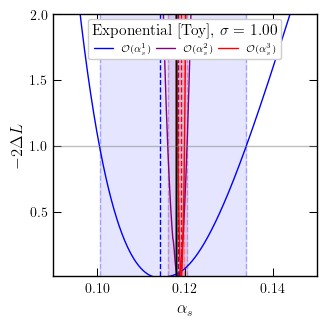

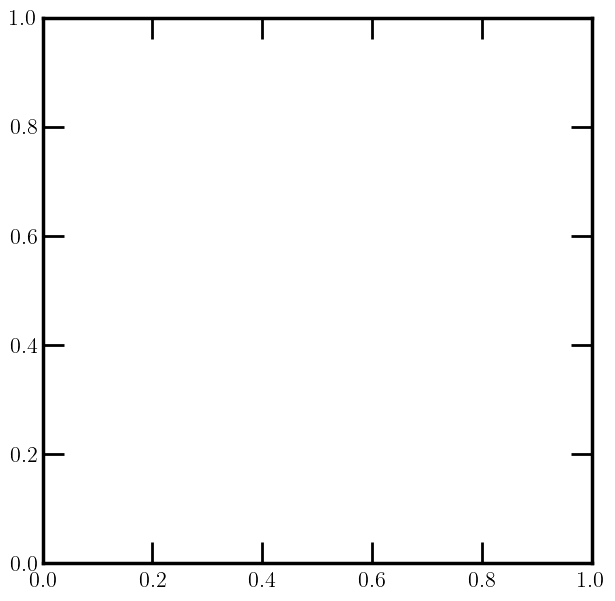

In [ ]:
fig, ax = newplot("column")

for mi in range(1, 4): 

    # try:

    
        with open(f"output_fits/alphas_{mi}_{n}_{tag}.pkl", "rb") as f:
            alphas = np.array(pickle.load(f))

        with open(f"output_fits/ls_{mi}_{n}_{tag}.pkl", "rb") as f:
            ls = np.array(pickle.load(f))


        idx = np.argsort(alphas)
        alphas = alphas[idx]
        ls = ls[idx]

        # For repeated alphas, take the minimum loss
        unique_alphas, unique_indices = np.unique(alphas, return_index=True)
        min_ls = []
        for ua in unique_alphas:
            mask = alphas == ua
            min_ls.append(np.min(ls[mask]))
        alphas = unique_alphas
        ls = np.array(min_ls)


        ls2 = 2 * ls

        min_ls = np.min(ls2)
        ls2 = ls2 - min_ls
        min_alpha = alphas[np.argmin(ls2)]

        alphas_below = alphas[ls2 < 1 + np.min(ls2)]
        low_alpha = alphas_below[0]
        high_alpha = alphas_below[-1]

        plus = high_alpha - min_alpha
        minus = min_alpha - low_alpha

        print(min_alpha, minus, plus)

        plt.plot(alphas, ls2, color = order_colors[mi], label = order_strings[mi])
        

        plt.axvline(min_alpha, color = order_colors[mi], ls = "--")
        plt.axvline(low_alpha, color = order_colors[mi], ls = "--", alpha = 0.25)
        plt.axvline(high_alpha, color = order_colors[mi], ls = "--", alpha = 0.25)

        # plt.fill_betweenx(y = [0,1e4], x1 = low_alpha, x2 = high_alpha, color = "white", alpha = 0.5)
        plt.fill_betweenx(y = [0,1e6], x1 = low_alpha, x2 = high_alpha, color = order_colors[mi], alpha = 0.1)

        # plt.yscale("log")
        plt.ylim(1e-2, 2e0)
        plt.xlim(0.09, 0.15)
        
        if dist is not "thrust":
            plt.axvline(0.118, color = "black")


        
plt.axhline(1.0, color = "gray", alpha = 0.5)

plt.xlabel(r"$\alpha_s$")
plt.ylabel(r"$-2\Delta L$")


            
if dist is "thrust":
    plt.axvline(0.118, color = "black", ls = "-", alpha = 0.75, label = "PDG")
    plt.scatter(0.1179, 1e-2, marker= "*", color = "black", s = 45, zorder = 10, clip_on=False)
    plt.scatter(0.1179, 1e-2, marker= "*", color = "white", s = 30, zorder = 10, clip_on=False)



plt.legend(title = title_dict[dist] + r", $\sigma = $" + f"{gaussian_prior_param : .2f}", loc = "upper center", ncol = 4, alignment='center', columnspacing = 0.5, facecolor='white', framealpha=1, frameon = True, fontsize = 7)
# plt.legend(title = title_dict[dist] + r", $\sigma = \infty$", loc = "upper left", ncol = 4, alignment='center', columnspacing = 0.5, facecolor='white', framealpha=1, frameon = True, fontsize = 7)

plt.savefig(f"figures/gaussian_{dist}{append}_linear.pdf", bbox_inches = "tight")

fix, ax = newplot("full")
dark_order_colors = order_colors


In [ ]:

# dist = "thrust"

# for a in ["", "_low", "_high", "_inf"]:
#     for mi in range(1, 4): 

#         t = f"gaussian_{dist}_stat_m0{m0}{a}"


        
#         with open(f"output_JAX/alphas_{mi}_{n}_{t}.pkl", "rb") as f:
#             alphas = np.array(pickle.load(f))

#         with open(f"output_JAX/ls_{mi}_{n}_{t}.pkl", "rb") as f:
#             ls = np.array(pickle.load(f))

#         with open(f"output_JAX/params_{mi}_{n}_{t}.pkl", "rb") as f:
#             ps = np.array(pickle.load(f))


#         # Save in new folder
#         with open(f"output_fits/alphas_{mi}_{n}_{t}_{t}.pkl", "wb") as f:
#             pickle.dump(alphas, f)

#         with open(f"output_fits/ls_{mi}_{n}_{t}_{t}.pkl", "wb") as f:
#             pickle.dump(ls, f)

#         with open(f"output_fits/params_{mi}_{n}_{t}_{t}.pkl", "wb") as f:
#             pickle.dump(ps, f)  


In [19]:
print(loss)

NameError: name 'loss' is not defined

In [ ]:
.7 * (len(tLEP_bin_centers))

29.4

for (i, l)